# Introduction

This notebook is to train VCNN model.

## Import Libraries

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2 
import os 
from os.path import join
from random import shuffle 
from tqdm import tqdm 
from PIL import Image

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score


import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

import warnings
import random
warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.10.0


In [35]:
! ls ../data/raw/real_vs_fake/real-vs-fake/

test  train  valid


In [36]:
train_pth = r'../data/raw/real_vs_fake/real-vs-fake/train/'
train_real = r'../data/raw/real_vs_fake/real-vs-fake/train/real/'
train_fake = r'../data/raw/real_vs_fake/real-vs-fake/train/fake/'

val_pth = r'../data/raw/real_vs_fake/real-vs-fake/valid/'
val_real = r'../data/raw/real_vs_fake/real-vs-fake/valid/real/'
val_fake = r'../data/raw/real_vs_fake/real-vs-fake/valid/fake/'

test_pth = r'../data/raw/real_vs_fake/real-vs-fake/test/'

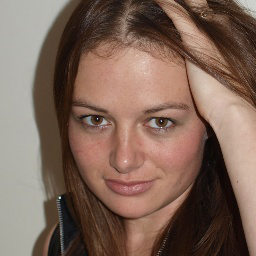

In [37]:
Image.open(join(train_real,random.choice(os.listdir(train_real))))


## Read train images

In [52]:
train = ImageDataGenerator()
val = ImageDataGenerator()
test = ImageDataGenerator()

train_dataset = train.flow_from_directory(train_pth,
                                          target_size=(256,256),
                                          batch_size = 32,
#                                           shuffle = False,
                                          class_mode = 'binary')
                                         
val_dataset = val.flow_from_directory(val_pth,
                                          target_size=(256,256),
                                          batch_size =32,
                                          class_mode = 'binary')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [53]:
train_dataset.class_indices

{'fake': 0, 'real': 1}

In [54]:
# train_dataset.classes.tolist()[::-1]
train_dataset.labels


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [55]:
# images, labels = next(train_dataset)
# labels

In [56]:
# [labels for _, labels in next(train_dataset)]

## Vannila CNN

In [57]:
model = Sequential()

# Convolutional layer and maxpool layer 1
model.add(layers.Conv2D(32,(5,5),activation='relu',input_shape=(256,256,3)))
model.add(layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(layers.Conv2D(64,(5,5),activation='relu'))
model.add(layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(layers.Dense(512,activation='relu'))

#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(layers.Dense(1,activation='sigmoid'))

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 122, 122, 64)      51264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 29, 29, 64)      

In [59]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [60]:
model.fit_generator(train_dataset,
         steps_per_epoch = 500,
         epochs = 10,
         validation_data = val_dataset
       )

Epoch 1/10
500/500 [==============================] - 168s 335ms/step - loss: 2.5459 - accuracy: 0.6102 - val_loss: 0.6223 - val_accuracy: 0.6597
Epoch 2/10
500/500 [==============================] - 171s 341ms/step - loss: 0.6067 - accuracy: 0.6754 - val_loss: 0.5640 - val_accuracy: 0.7110
Epoch 3/10
500/500 [==============================] - 169s 338ms/step - loss: 0.5534 - accuracy: 0.7200 - val_loss: 0.5459 - val_accuracy: 0.7212
Epoch 4/10
500/500 [==============================] - 165s 330ms/step - loss: 0.5210 - accuracy: 0.7456 - val_loss: 0.5129 - val_accuracy: 0.7521
Epoch 5/10
500/500 [==============================] - 172s 343ms/step - loss: 0.5117 - accuracy: 0.7519 - val_loss: 0.5031 - val_accuracy: 0.7606
Epoch 6/10
500/500 [==============================] - 169s 337ms/step - loss: 0.4706 - accuracy: 0.7778 - val_loss: 0.4361 - val_accuracy: 0.7990
Epoch 7/10
500/500 [==============================] - 169s 338ms/step - loss: 0.4351 - accuracy: 0.8005 - val_loss: 0.4409 -

In [61]:
def predictImage(filename, THRESH = 0.5):
    img1 = image.load_img(filename,target_size=(256,256))
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
#     print(val)
    if val > THRESH:
        plt.xlabel("PREDICTED : REAL",fontsize=30)
    else:
        plt.xlabel("PREDICTED : FAKE",fontsize=30)

ORIGINAL CLASS : REAL
1/1 [==============================] - 0s 153ms/step


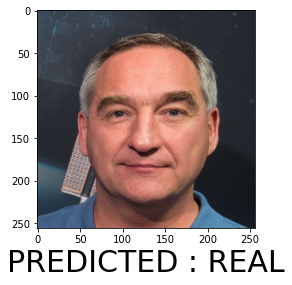

In [62]:
random_real_image = join(val_real,random.choice(os.listdir(val_real)))
print('ORIGINAL CLASS : REAL')
predictImage(random_real_image)

### Validation result

In [74]:
val_dataset = val.flow_from_directory(val_pth,
                                          target_size=(256,256),
                                          batch_size =32,
                                          shuffle = False,
                                          class_mode = 'binary')

Found 20000 images belonging to 2 classes.


In [75]:
THRESH = 0.5
val_predict = model.predict(val_dataset).reshape(-1)
val_predict = np.where(val_predict > THRESH,1,0)
val_predict.shape

625/625 [==============================] - 85s 136ms/step


(20000,)

In [76]:
val_predict

array([0, 0, 0, ..., 1, 0, 1])

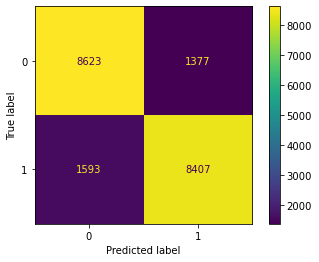

In [77]:
cm = confusion_matrix(val_dataset.classes, val_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

plt.show()

In [78]:
f1_score(val_dataset.classes, val_predict)

0.8498786898503842

In [79]:
score = model.evaluate(val_dataset,batch_size = 32)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

625/625 [==============================] - 85s 136ms/step - loss: 0.3514 - accuracy: 0.8515
Validation loss: 0.35141289234161377
Validation accuracy: 0.8514999747276306


In [80]:
print('Validation Acc: ', 100*np.sum(val_predict == val_dataset.classes)/len(val_dataset.classes))


Validation Acc:  85.15


### Test result

In [64]:
test_dataset = test.flow_from_directory(test_pth,
                                          target_size=(256,256),
                                          batch_size =32,
                                          shuffle = False,
                                          class_mode = 'binary')

Found 20000 images belonging to 2 classes.


In [70]:
THRESH=0.5
test_predict = model.predict_generator(test_dataset)
test_predict = np.where(test_predict > THRESH,1,0)

test_predict

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

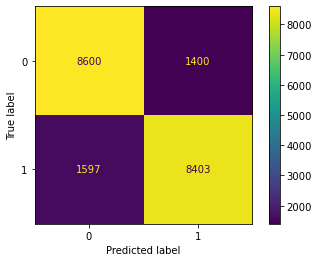

In [71]:
cm = confusion_matrix(test_dataset.classes, test_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

In [72]:
f1_score(test_dataset.classes, test_predict)

0.8486592940463566

In [81]:
score = model.evaluate_generator(test_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3504398465156555
Test accuracy: 0.8501499891281128
